# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [3]:
%%capture

! pip install lightgbm

In [4]:
# загрузка библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [5]:
# настройки ноутбука
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

## Подготовка данных

In [6]:
df = pd.read_csv('/datasets/autos.csv') # загрузим данные

In [7]:
df.head(5) 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
df.info(), df.isna().sum() #157139

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

(None,
 DateCrawled              0
 Price                    0
 VehicleType          37490
 RegistrationYear         0
 Gearbox              19833
 Power                    0
 Model                19705
 Kilometer                0
 RegistrationMonth        0
 FuelType             32895
 Brand                    0
 Repaired             71154
 DateCreated              0
 NumberOfPictures         0
 PostalCode               0
 LastSeen                 0
 dtype: int64)

В данных есть пропуски и нарушены типы данных. 
План очистки:
    
    1) преобразовать типы данных; 
    2) удалить дубликаты (явные и неявные);
    3) заполнить пропуски;
    4) изучить аномалии, выбросы, очистить данные;
    5) изучить информативность и важность признаков.

### Преобразование типов данных; 

In [9]:
# дата создания объявления очень важный признак, его стоит не только преобразовать, но и распарсить.
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d') # запишем дату создания, как дату
df['day_created'] = df['DateCreated'].dt.day
df['weekday_created'] = df['DateCreated'].dt.day_name()       # создадим также название дня недели
df['month_created'] = df['DateCreated'].dt.month              # поскольку может наблюдаться сезонность, например, на кабиролеты, то можно добавить признак - месяц.
df['year_created'] = df['DateCreated'].dt.year                # год создания анкеты может также влиять на цену.

In [10]:
# А вот дата скачивания объявления кажется не очень важный признак. Тем не менее, можно достать год и месяц.
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d')
df['month_crewled'] = df['DateCrawled'].dt.month
df['month_crewled'] = df['DateCrawled'].dt.year

In [11]:
df['LastSeen'].head(2)

0    2016-04-07 03:16:57
1    2016-04-07 01:46:50
Name: LastSeen, dtype: object

In [12]:
# дата последней активности пользователя может быть очень полезным признаком. Поскольку если пользователь давно не активен, 
# то возможно, и его объявление уже давно не активно
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')
df['last_seen_hour'] = df['LastSeen'].dt.hour
df['last_seen_day'] = df['LastSeen'].dt.day
df['last_seen_weekday'] = df['LastSeen'].dt.day_name()
df['last_seen_month'] = df['LastSeen'].dt.month
df['last_seen_year'] = df['LastSeen'].dt.year

In [13]:
# далее удалим распаршенные признаки, чтобы избежать мультиколенниарности
df = df.drop(columns=['DateCreated', 'LastSeen', 'DateCrawled'], axis=1)

In [14]:
# снизим кодировку, с целью сокращения ресурсов памяти
num_columns = df.select_dtypes('int64').columns   # отберём числовые колонки
df[num_columns] = df[num_columns].astype('int32')

### Избавление от дубликатов

In [15]:
print(df.shape)
df = df.drop_duplicates() # на всякий случай :)
print(df.shape)
cat_columns = df.select_dtypes('object').columns  # отберём нечисловые колонки

(354369, 23)
(352023, 23)


In [16]:
for c_n in cat_columns:
    # отсортируем для удобства отслеживания дубликатов
    print(f'Уникальные значения в признаке {c_n}:', sorted([str(v) for v in df[c_n].unique()]), '\n') 

Уникальные значения в признаке VehicleType: ['bus', 'convertible', 'coupe', 'nan', 'other', 'sedan', 'small', 'suv', 'wagon'] 

Уникальные значения в признаке Gearbox: ['auto', 'manual', 'nan'] 

Уникальные значения в признаке Model: ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cu

**Дубликаты отсутсвуют.**

### Избавление от пропусков

In [17]:
# создадим объект, по которому должна осуществляться проверка пропусков

test = df.query('Brand == "audi" & VehicleType == "coupe" & Power == 190 & FuelType == "gasoline" & RegistrationYear == 2011')

In [18]:
display(test)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,day_created,weekday_created,month_created,year_created,month_crewled,last_seen_hour,last_seen_day,last_seen_weekday,last_seen_month,last_seen_year
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954,24,Thursday,3,2016,2016,1,7,Thursday,4,2016
132908,12900,coupe,2011,manual,190,a5,150000,2,gasoline,audi,no,0,87600,1,Friday,4,2016,2016,11,3,Sunday,4,2016
208791,16900,coupe,2011,manual,190,a5,150000,1,gasoline,audi,no,0,76646,11,Friday,3,2016,2016,6,22,Tuesday,3,2016


In [19]:
# для заполнения категориальных пропусков, будем использовать колонки, которые идентифицируют потенциальный модельный ряд автомобиля
target_columns = ['VehicleType', 'RegistrationYear', 'Power', 'Model', 'FuelType', 'Brand', 'Kilometer']


# отберём реально существующие авто
car_df = (df[target_columns]
         .pivot_table(index=['VehicleType', 'RegistrationYear', 'Power', 'Model', 'FuelType', 'Brand'])
         .reset_index()
         .drop('Kilometer', axis=1))

car_df = car_df[car_df['Power'] > 0].drop_duplicates() # как мощность может быть равна 0? исправим это.

In [20]:
# Также преобразуем и в основном фрейме
df['Power'] = df['Power'].replace(0, np.nan)

In [21]:
%%time

# создадим словарь для быстрого доступа к наборам данных
car_data_dict = {}

# заполним словарь данными из car_df
for car_arr in car_df.values:
    brand = car_arr[-1]
    year = car_arr[1]
    if brand not in car_data_dict:
        car_data_dict[brand] = {}
    if year not in car_data_dict[brand]:
        car_data_dict[brand][year] = []
    car_data_dict[brand][year].append(car_arr)

CPU times: user 30.2 ms, sys: 7.56 ms, total: 37.7 ms
Wall time: 45.7 ms


In [22]:
%%time

df_clean = []  # создадим пустой список, в который будем добавлять результаты

# для каждого значения в исходных данных
for arr in df[target_columns[:-1]].values:
    nan_indices = [i for i, x in enumerate(arr) if isinstance(x, float) and np.isnan(x)]  # отберем индексы нулевых значений
    
    if np.any(nan_indices):
        
        brand = arr[-1]  # бренд авто
        year = arr[1]    # год регистрации
        target_values = np.delete(arr, nan_indices)  # отбираем целевые значения, которые не являются NaN
        
        if brand in car_data_dict.keys() and year in car_data_dict[brand]: # если бренд и год для бренда есть в словаре
            car_data = car_data_dict[brand][year]                          # тогда обратимся к этой ячейке
            for car_arr in car_data:                                    # пройдёмся циклом по данным, которые там представлены
                car_arr_cleaned = np.delete(car_arr, nan_indices)   # удалим индексы, с пропущенными данными 
                if (target_values==car_arr_cleaned).all():          # если объект без учётов пропусков идентичен
                    df_clean.append(car_arr)                        # добавляем полный объект в цикл
                    break
            else:
                df_clean.append(arr)
        else:
            df_clean.append(arr)
    else:
        df_clean.append(arr)

df_clean = pd.DataFrame(df_clean, columns=target_columns[:-1])  # преобразуем список в DataFrame

CPU times: user 43.1 s, sys: 74.5 ms, total: 43.2 s
Wall time: 43.3 s


In [23]:
# теперь заменим пропуски
df[target_columns[:-1]] = df_clean
df.isna().sum().sort_values()

Price                    0
last_seen_weekday        0
last_seen_day            0
last_seen_hour           0
month_crewled            0
year_created             0
month_created            0
weekday_created          0
day_created              0
PostalCode               0
last_seen_month          0
NumberOfPictures         0
RegistrationMonth        0
Kilometer                0
last_seen_year           0
Brand                 2311
RegistrationYear      2311
Power                 9766
Model                 9822
FuelType             14225
Gearbox              19794
VehicleType          27910
Repaired             71000
dtype: int64

In [24]:
# пропусков стало меньше, однако, есть столбец Repaired, который содержит очень много пропусков.
# Исправить это можно использовав данные о годе авто и о его мощности. Подразумевая, что более быстрые авто чаще требуют
# починки
def speed(x):
    if x >= 300:
        return 'монщое авто'
    elif x >= 150 and x < 300:
        return 'авто средней мощности'
    elif x < 150:
        return 'мало-мощное авто'
    else:
        return 'не определенно'

In [25]:
# категории скорости
df['speed_auto'] = df.Power.apply(lambda x: speed(x))

# сводная
df_speed = df.pivot_table(index=['Brand', 'RegistrationYear', 'speed_auto'],
                          columns='Repaired',
                          values='last_seen_year',
                          aggfunc='count').reset_index()
# заменим np.nan на 0
df_speed[['no', 'yes']] = df_speed[['no', 'yes']].fillna(0)

# определим, что с большей вероятностью характерно для автобиля
df_speed['target'] = ['yes' if y > n else 'no' for n, y in zip(df_speed['no'], df_speed['yes'])]

# удалим лишние столбцы
df_speed.drop(columns=['no', 'yes'], inplace=True)

In [26]:
# теперь добавим таргет к нашим данным
df = df.merge(df_speed)

# заменим пропуски и дронем лишнее
df['Repaired'] = df['Repaired'].fillna(df['target'])
df.drop(columns='target', inplace=True)

In [27]:
df[df.isna().any(axis=1)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,day_created,weekday_created,month_created,year_created,month_crewled,last_seen_hour,last_seen_day,last_seen_weekday,last_seen_month,last_seen_year,speed_auto
15,820,wagon,1993.0,NaN,90.0,passat,150000,4,gasoline,volkswagen,no,0,28329,1,Friday,4,2016,2016,9,7,Thursday,4,2016,мало-мощное авто
18,699,small,1993.0,NaN,40.0,polo,150000,0,petrol,volkswagen,no,0,51147,31,Thursday,3,2016,2016,19,31,Thursday,3,2016,мало-мощное авто
38,1990,wagon,1993.0,manual,74.0,golf,125000,9,NaN,volkswagen,yes,0,15236,18,Friday,3,2016,2016,22,5,Tuesday,4,2016,мало-мощное авто
49,15750,small,1993.0,NaN,115.0,golf,40000,0,petrol,volkswagen,no,0,79713,22,Tuesday,3,2016,2016,10,7,Thursday,4,2016,мало-мощное авто
77,0,sedan,1993.0,NaN,75.0,golf,150000,0,petrol,volkswagen,no,0,41379,18,Friday,3,2016,2016,6,19,Saturday,3,2016,мало-мощное авто
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349426,1550,NaN,2017.0,NaN,307.0,NaN,150000,6,NaN,honda,no,0,1159,21,Monday,3,2016,2016,6,6,Wednesday,4,2016,монщое авто
349428,4500,coupe,1995.0,manual,305.0,NaN,150000,9,petrol,sonstige_autos,no,0,47137,12,Saturday,3,2016,2016,21,19,Saturday,3,2016,монщое авто
349429,2800,bus,1982.0,manual,NaN,other,80000,6,petrol,renault,no,0,96103,2,Saturday,4,2016,2016,12,6,Wednesday,4,2016,не определенно
349430,1595,NaN,1800.0,auto,16.0,other,150000,3,petrol,fiat,no,0,50969,11,Friday,3,2016,2016,0,28,Monday,3,2016,мало-мощное авто


In [28]:
# отсортируем датафрейм по категориям бренда, модели и года регистрации
df.sort_values(by=['Brand', 'Model', 'RegistrationYear'], inplace=True)

In [29]:
# после такой сортировки, можно предположить, что стоящие рядом объекты в наибольшей степени похожи друг на друга.
# поэтому пропуски в таких признаках, как "VehicleType", "Gearbox" и "FuelType", можно заполнить опираясь на инф-цию ниже. 
df['VehicleType'].fillna(method='bfill', inplace=True)
df['VehicleType'].fillna(method='ffill', inplace=True)

df['FuelType'].fillna(method='bfill', inplace=True)
df['FuelType'].fillna(method='ffill', inplace=True)

df['Gearbox'].fillna(method='bfill', inplace=True)
df['Gearbox'].fillna(method='ffill', inplace=True)

In [30]:
# мощность можно заменить, использовав среднее значение по группам категорий  
df_power_swod = (df[df['Power'].notna()].pivot_table(index=['Brand', 'Model', 'RegistrationYear', 'VehicleType', 'FuelType'],
                                    values='Power',
                                    aggfunc='mean')
                 .reset_index()) # создадим таблицу для отбора средней мощности

df_power_swod.rename(columns={'Power': 'power_mean'}, inplace=True) # переименуем столбец


df = df.merge(df_power_swod, how='left')                  # соединим созданные фреймы 
df['Power'] = df['Power'].fillna(df['power_mean'])        # заменим пропуски на среднее значение для группы
df['Power'] = df['Power'].fillna(df['Power'].mean())      # для остальных просто возьмём среднее значение
df.drop(columns='power_mean', axis=1, inplace=True)       # удалим лишний столббец

# для модели просто заменим неизвестные на unknown.

df.Model.fillna('unknown', inplace=True)

In [29]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
NumberOfPictures     0
PostalCode           0
day_created          0
weekday_created      0
month_created        0
year_created         0
month_crewled        0
last_seen_hour       0
last_seen_day        0
last_seen_weekday    0
last_seen_month      0
last_seen_year       0
speed_auto           0
dtype: int64

**Теперь пропуски отсутствуют**

### Избавление от статистических выбросов

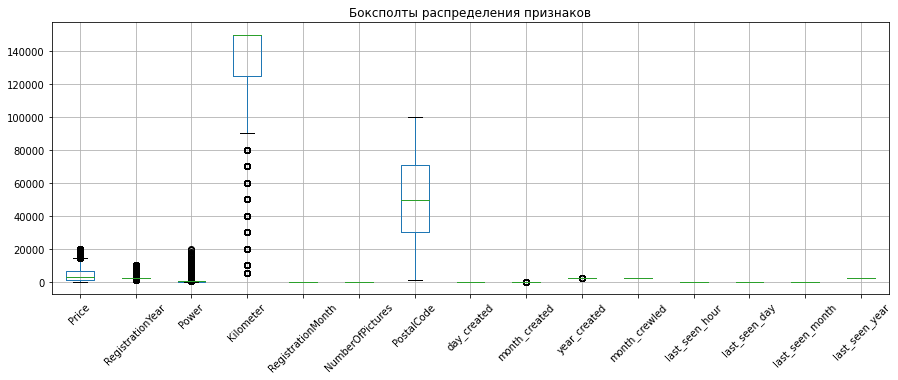

In [30]:
# последним этапом предобработки станет очиска от статичтиеских выбросов. 
plt.figure(figsize=(15, 5))
plt.title('Боксполты распределения признаков')
df.boxplot()
plt.xticks(rotation=45)
plt.show()

In [32]:
# удалим выбросы в столбцах 
max_price = df['Price'].quantile(0.75) * 1.5
max_power= df['Power'].quantile(0.75) * 1.5

df = df.query('Price < @max_price')
df = df.query('Power < @max_power')
df = df.query('RegistrationYear < 2023 & RegistrationYear > 1985')

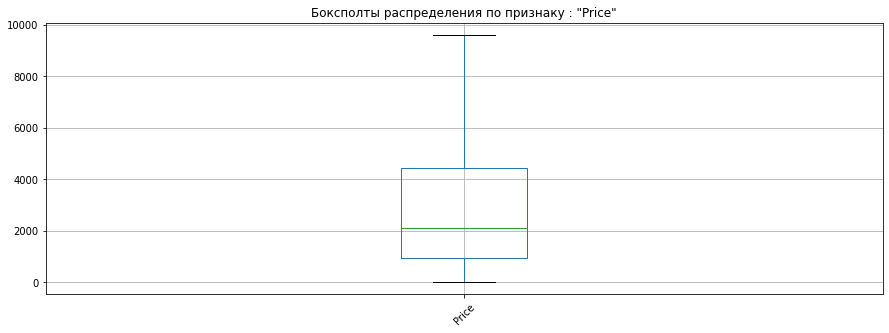

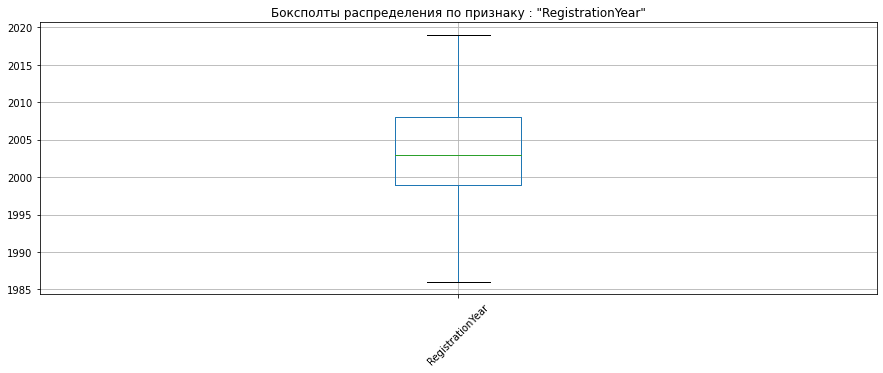

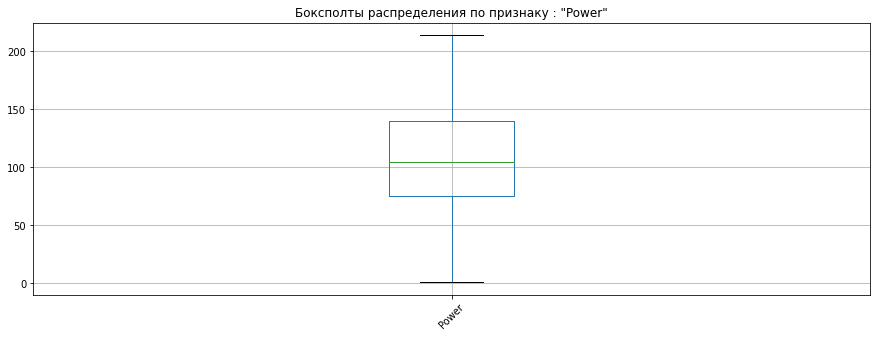

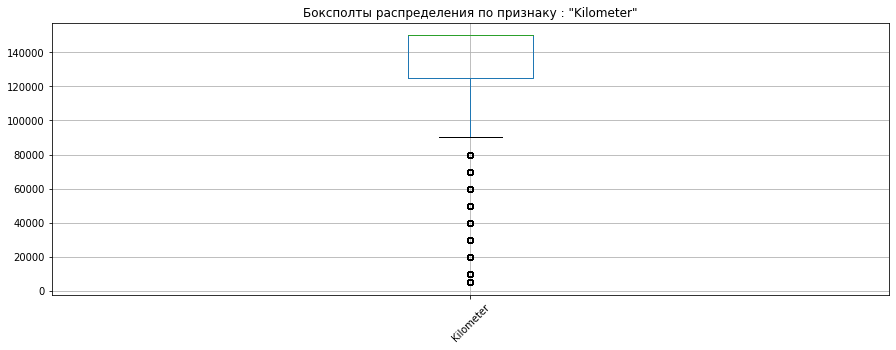

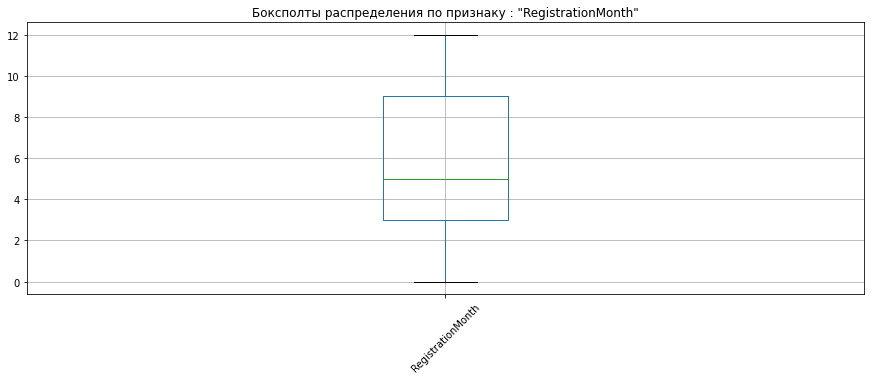

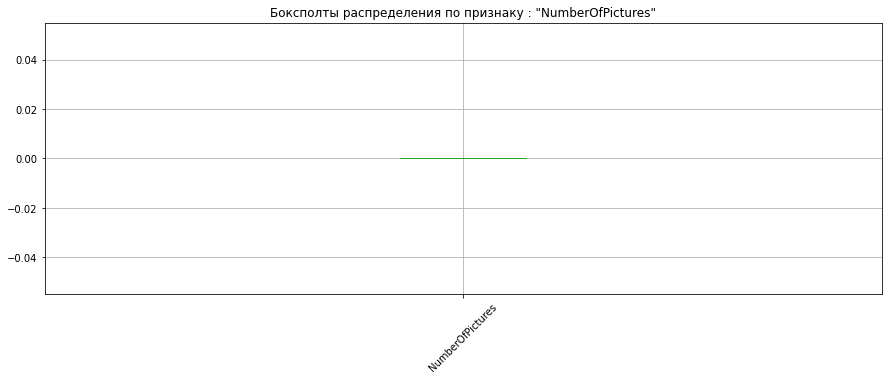

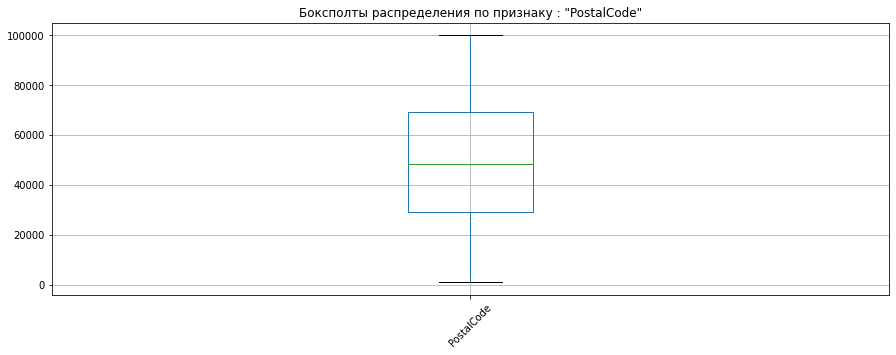

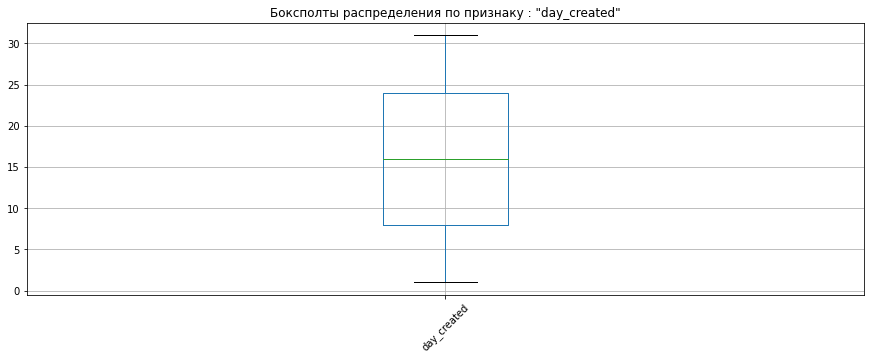

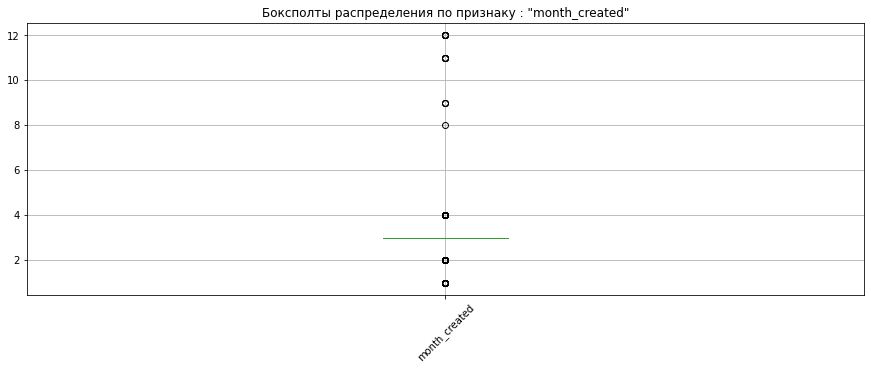

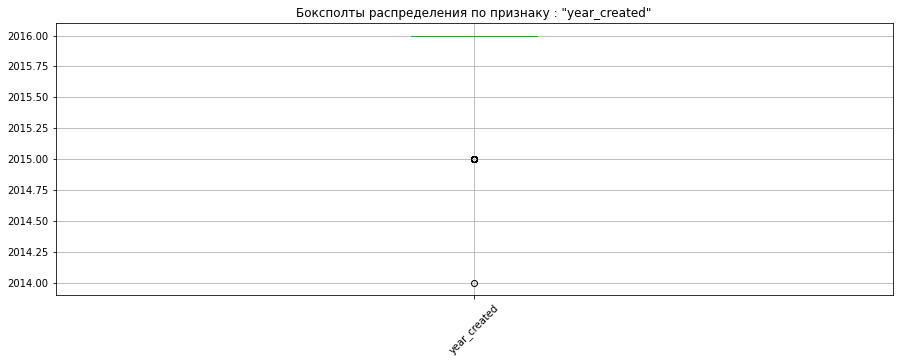

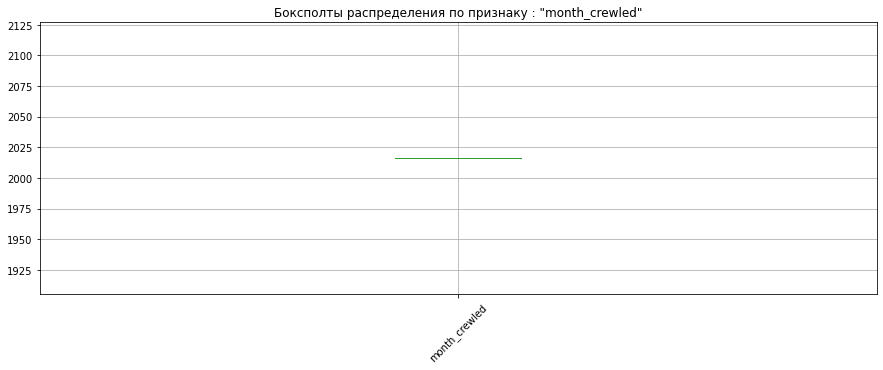

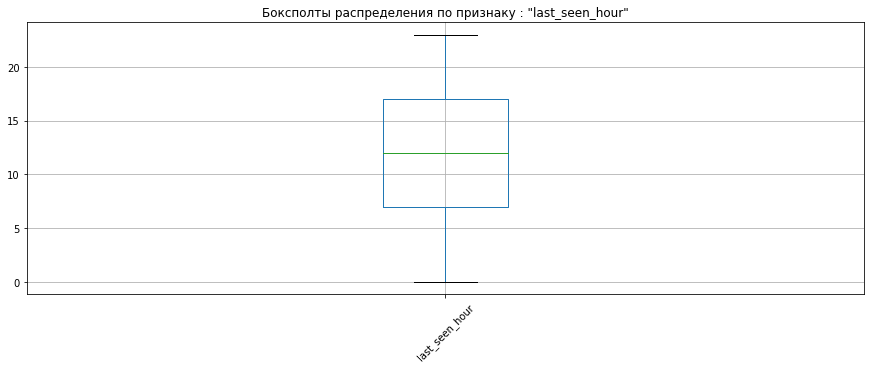

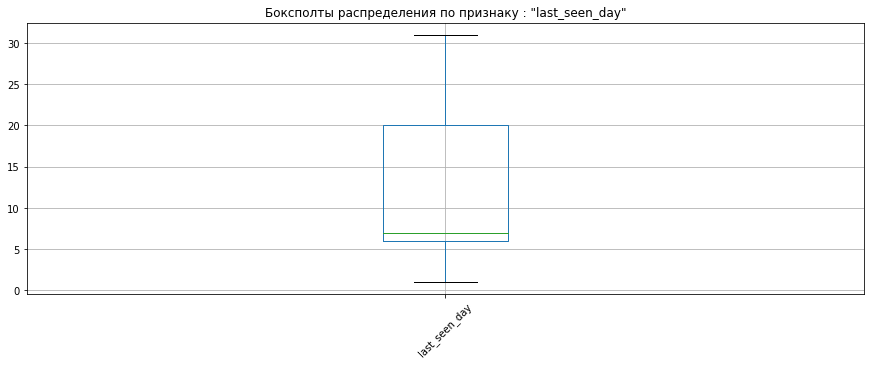

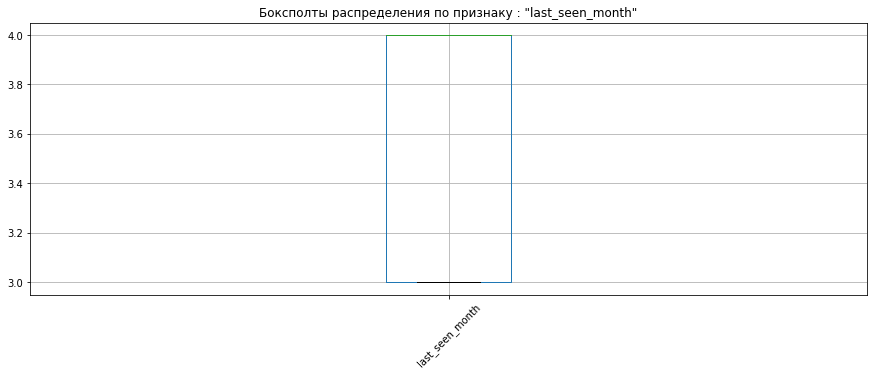

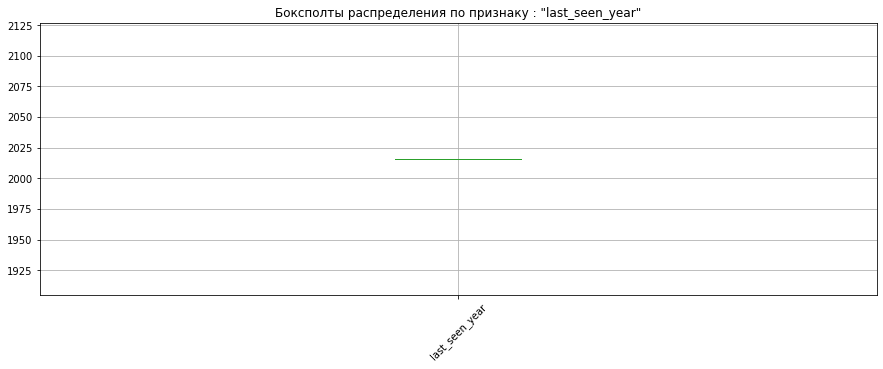

In [33]:
# последним этапом предобработки станет очиска от статичтиеских выбросов. 
for i in df.select_dtypes(exclude='object').columns:
    plt.figure(figsize=(15, 5))
    plt.title(f'Боксполты распределения по признаку : "{i}"')
    df.boxplot(column=i)
    plt.xticks(rotation=45)
    plt.show()

In [41]:
q_low = df.Price.quantile(0.25)/1.5
df = df.query('Price > @q_low')
df = df.query('Power > 40')

**Теперь данные предобработаны**

In [42]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,day_created,month_created,year_created,month_crewled,last_seen_hour,last_seen_day,last_seen_month,last_seen_year
count,204348.000000,204348.000000,204348.000000,204348.000000,204348.000000,204348.0,204348.000000,204348.000000,204348.000000,204348.000000,204348.0,204348.000000,204348.000000,204348.000000,204348.0
mean,3774.089617,2003.643623,109.831398,131451.592382,5.955639,0.0,50659.429326,15.837468,3.161015,2015.999936,2016.0,11.829467,11.961707,3.565075,2016.0
std,2343.682079,6.408342,39.719314,34001.189720,3.639299,0.0,25584.075027,9.131160,0.375879,0.008567,0.0,6.518435,8.892403,0.495748,0.0
min,968.000000,1986.000000,41.000000,5000.000000,0.000000,0.0,1067.000000,1.000000,1.000000,2014.000000,2016.0,0.000000,1.000000,3.000000,2016.0
25%,1800.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30459.000000,8.000000,3.000000,2016.000000,2016.0,7.000000,6.000000,3.000000,2016.0
50%,3099.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49509.000000,16.000000,3.000000,2016.000000,2016.0,12.000000,7.000000,4.000000,2016.0
75%,5400.000000,2008.000000,140.000000,150000.000000,9.000000,0.0,71063.000000,24.000000,3.000000,2016.000000,2016.0,17.000000,19.000000,4.000000,2016.0
max,9599.000000,2019.000000,214.000000,150000.000000,12.000000,0.0,99998.000000,31.000000,12.000000,2016.000000,2016.0,23.000000,31.000000,4.000000,2016.0


## Обучение моделей

In [44]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include='object').columns

numeric_transformer = StandardScaler()
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)  

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

steps = [
    ('preprocessor', preprocessor),
]

# Создание Pipeline
pipeline = Pipeline(steps)




y = df.Price                         # таргет
X = df.drop(columns='Price', axis=1) # признаки

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [46]:
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

abs_scores = np.abs(scores)
mean_scores = np.mean(abs_scores)
rmse = np.sqrt(mean_scores)
print(f'RMSE для выбранного пайплайна и линейной регрессии составляет: {round(rmse, 0)}')

RMSE для выбранного пайплайна и линейной регрессии составляет: 2305.0


**Несмотря на то, что результат модели уже соотвествует требованию метрики, засчёт качественной предобработки, исследуем возможность применения градиентного бустинга**

In [47]:
def rmse(actual, predict):
    '''
    Инциализируем метрику rmse для оценки качества LGBM
    '''
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

# Обучаем предпроцессор на тренировочных данных
pipeline.fit(X_train)

# Преобразуем тренировочные и тестовые данные с помощью предпроцессора
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

# Инициализируем модель LGBMRegressor
model = LGBMRegressor(random_state=42, force_row_wise=True)

# Задаем параметры для поиска по сетке
LGBMR_param = {
    'num_leaves': [20, 30, 40, 50],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 300]
}

# Инициализируем GridSearchCV с моделью, параметрами и оценочной метрикой
clf = RandomizedSearchCV(model, LGBMR_param, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=10, cv=3, random_state=42)

# Обучаем модель на тренировочных данных с поиском по сетке
clf.fit(X_train, y_train)

# Выводим лучшую оценку RMSE
print('Лучшее RMSE:', np.sqrt(-clf.best_score_))

**Лучшая модель:**

    LGBMRegressor(force_row_wise=True, learning_rate=0.01, max_depth=10,
              n_estimators=300, num_leaves=50, random_state=42)

## Анализ модели

In [46]:
%%time
# Сначала оценим качество модели бустинга и скорость обучения, выполнения:

# проверим лучший эстимейтор, на полном объёме данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем предпроцессор на тренировочных данных
pipeline.fit(X_train)

# Преобразуем тренировочные и тестовые данные с помощью предпроцессора
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

# инциализируем лучший эстимейтор
best_model = clf.best_estimator_
best_model.fit(X_train, y_train)

# рассчитаем RMSE на лучшей моделе
y_pred = best_model.predict(X_test)
print('RMSE:', rmse(y_test, y_pred))

RMSE: 2399.076722401144
CPU times: user 22.6 s, sys: 388 ms, total: 23 s
Wall time: 23.3 s


In [47]:
%%time
# теперь изучим время выполнения предсказания

y_pred = best_model.predict(X_test)

CPU times: user 1.18 s, sys: 239 µs, total: 1.18 s
Wall time: 1.12 s


In [48]:
%%time
# Теперь изучим модель для Линейной регрессии:

# проверим лучший эстимейтор, на полном объёме данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем предпроцессор на тренировочных данных
pipeline.fit(X_train)

# Преобразуем тренировочные и тестовые данные с помощью предпроцессора
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

# инциализируем лучший эстимейтор
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# рассчитаем RMSE на лучшей моделе
y_pred = lin_reg.predict(X_test)
print('RMSE:', rmse(y_test, y_pred))

RMSE: 2403.915949331413
CPU times: user 1.82 s, sys: 25.1 ms, total: 1.85 s
Wall time: 1.81 s


In [49]:
%%time
# теперь изучим время выполнения предсказания

y_pred = best_model.predict(X_test)

CPU times: user 1.19 s, sys: 50.1 ms, total: 1.24 s
Wall time: 1.3 s


## Вывод

Было проверено 2 модели, модель градиентного бустинга и линейная регрессия.
В результате проверки выяснилось, что модель градиентного бустинга показывает результаты немного лучше. При этом, обучение модели занимает гораздо больше времени, а вот скорость предсказания быстрее, чем у линейной модели.
Таким образом, под задачи заказчика лучше подходит модель градиентного бустинга.